# S&P 500 Stocks Analysis

### This notebook is created as a practice of computer based stock analysis using time series algorithm.

## Import Libraries

In [49]:
# Import Libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stationarity
from statsmodels.tsa.stattools import adfuller

# Decomposition
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

# Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Saving
import joblib

## Load Dataset

In [50]:
# Load Data set
df = pd.read_csv('HistoricalData_1724063573484.csv')
df

,Date,Close/Last,Open,High,Low
0,08/16/2024,5554.25,5530.50,5561.98,5525.17
1,08/15/2024,5543.22,5501.13,5546.23,5501.13
2,08/14/2024,5455.21,5442.36,5463.22,5415.91
3,08/13/2024,5434.43,5376.98,5436.50,5376.98
4,08/12/2024,5344.39,5351.88,5371.20,5324.37
...,...,...,...,...,...
1253,08/23/2019,2847.11,2911.07,2927.01,2834.97
1254,08/22/2019,2922.95,2930.94,2939.08,2904.51
1255,08/21/2019,2924.43,2922.04,2928.73,2917.91
1256,08/20/2019,2900.51,2919.01,2923.63,2899.60


First of all, we needed to see how the data looks like. So, we load the dataset and show it.

In [51]:
# See dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1258 non-null   object 
 1   Close/Last  1258 non-null   float64
 2   Open        1258 non-null   float64
 3   High        1258 non-null   float64
 4   Low         1258 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.3+ KB


- The s&p500 historical data consists of 5 columns.
- In which, there are Date, Close/Last, Open, High, and Low columns.
- Each of these columns have 1258 entries.
- The column 'Date' is not in a desirable format, in which should be date format. Therefore, we will fix it.
- The rest of the columns are in the right format which is float.

In [52]:
# Covert column 'Date' from object format to date format
df["Date"] = pd.to_datetime(df["Date"])

The date column are fixed into the desirable datetime format.

In [53]:
# See missing value in the dataset
df.isnull().sum()

Date          0
Close/Last    0
Open          0
High          0
Low           0
dtype: int64

There are no missing value in these data, which means that we can skip missing value handling process.

Since we are only going to analyze the final value of the stock price, we will only keep the Date (as index) and Close/Last columns. The rest of the columns are going to be erased.

In [54]:
# Delete 'Open', 'High', 'Low' columns
df = df.drop(labels=['Open', 'High', 'Low'], axis=1)

## Train Test Split


In [55]:
# Train test split
train = df[0:1000]
test = df[1000:]

test.tail()

,Date,Close/Last
1253,2019-08-23,2847.11
1254,2019-08-22,2922.95
1255,2019-08-21,2924.43
1256,2019-08-20,2900.51
1257,2019-08-19,2923.65


Train set will be the first 1000 data and the rest are the test data.

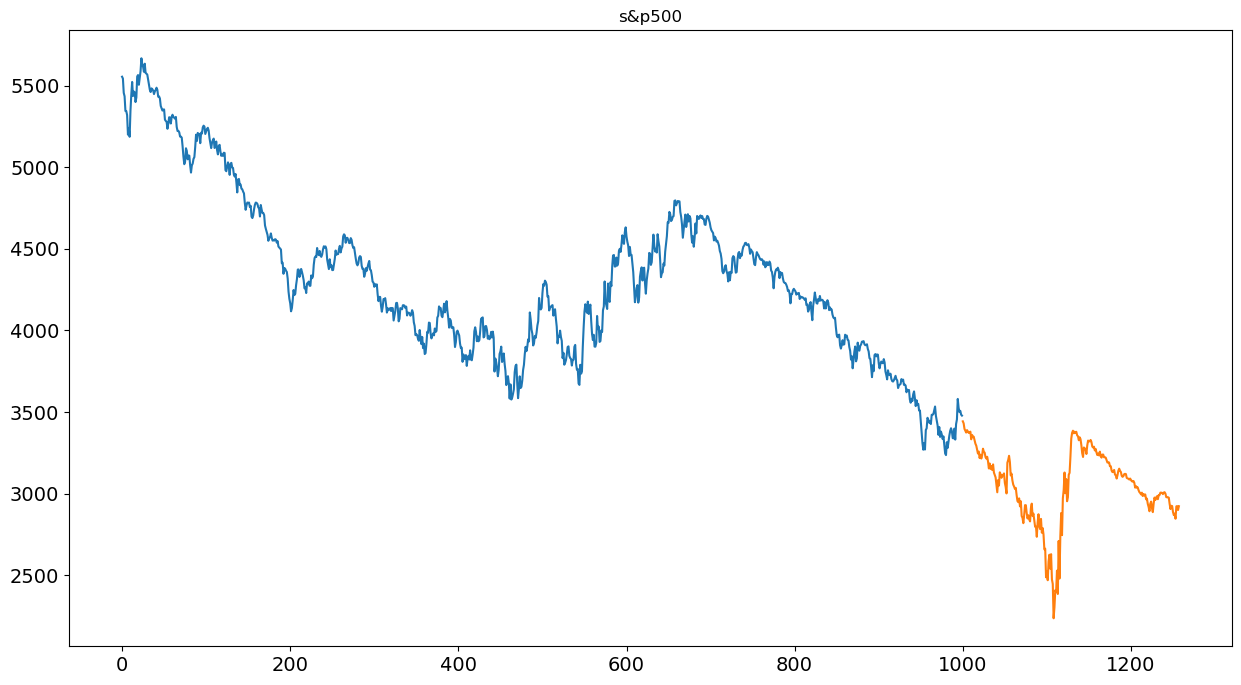

In [56]:
# Look at graph
train['Close/Last'].plot(figsize=(15,8), title='s&p500', fontsize=14)
test['Close/Last'].plot(figsize=(15,8), title='s&p500', fontsize=14)
plt.show()


Here is the overview of the graph. The blue line represent the train dataset and the orange line represent the test set.

## Decomposition

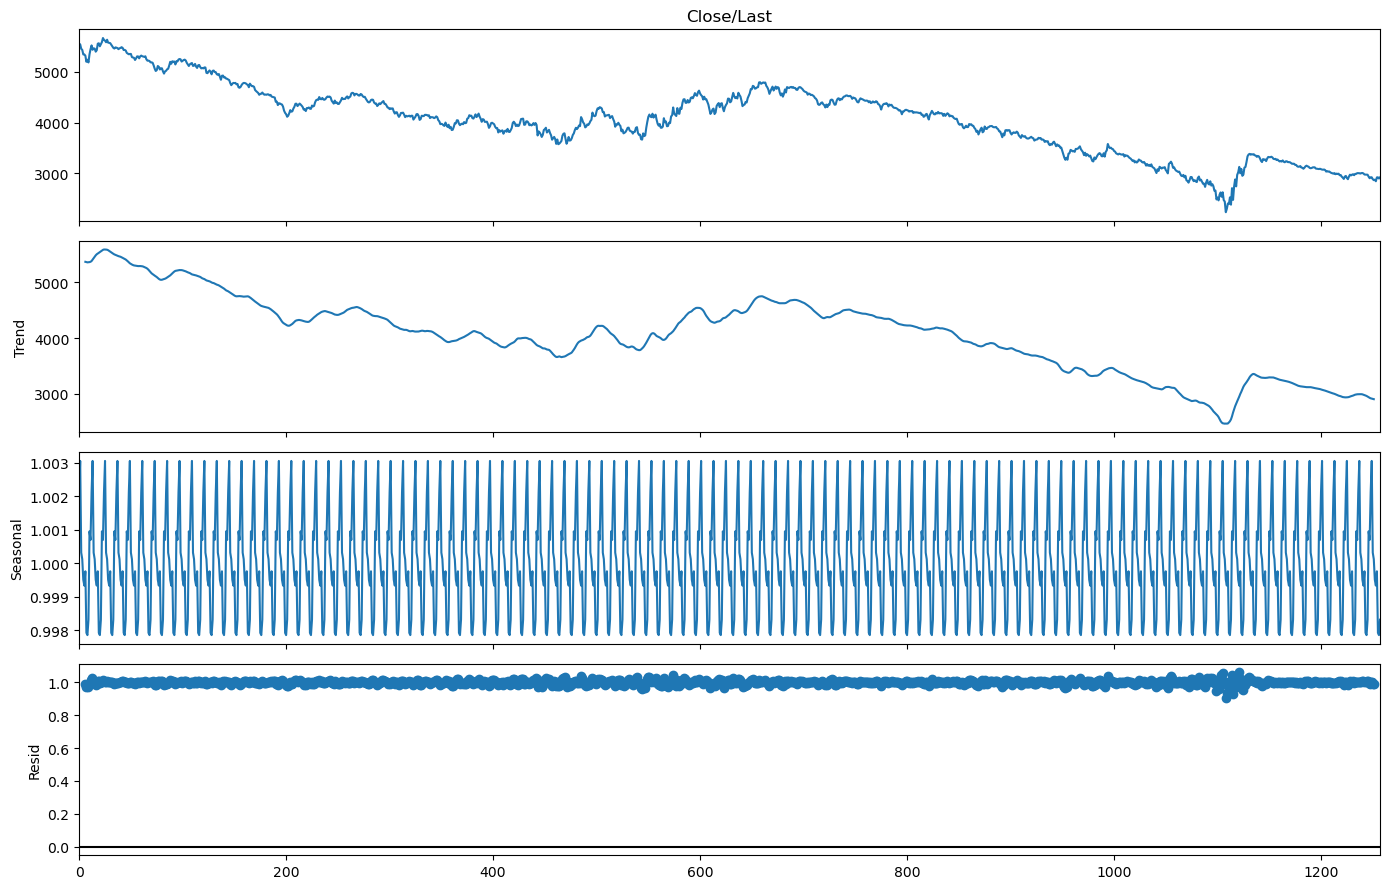

In [57]:
# Set the figure size
rcParams['figure.figsize'] = (14, 9)

# Perform the seasonal decomposition
res = seasonal_decompose(df['Close/Last'], model='multiplicative', period=12)

# Plot the results
ax = res.plot()
plt.show()

Next, we break down the complex problems into simpler parts for better understanding. The components that are broken down (in order) are the trend, seasonality, and residual.
- Trend: The direction where the data is going over a period of time.
- Seasonality: Regular patterns or cycles that repeat at specific intervals.
- Residual/Noise: Random variations apart from the trend and seasonality, in which are unpredictable and/or irregular.

## Stationarity

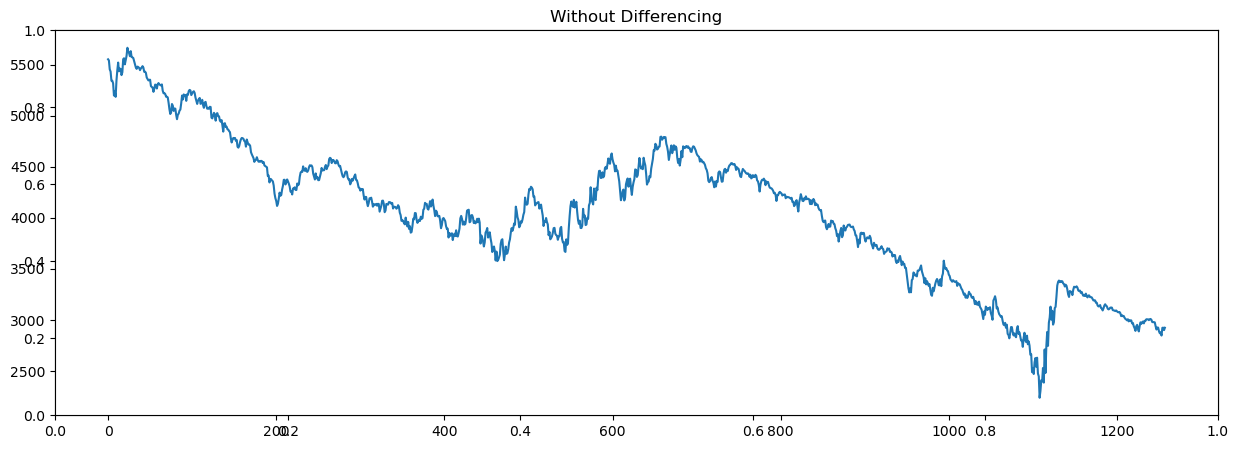

In [58]:
# Plot without differencing
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Without Differencing')
ax1.plot(df['Close/Last'])

Then, we needed to make the the series into stationary (differencing), which means the trends and seasonality are removed. This purpose is to make the statistical properties like mean and variance constant. Differencing helps in stabilizing the mean, making it easier to model and forecast. Here is the overview of what it looks like without differencing. 

In [59]:
# Check for stationarity
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In order for a simple check, we made the function to check it's stationarity. Where the p-value is less than or equal to 0.05 and the ADF Statistic is less than the 5% critical value. 

In [60]:
check_stationarity(train['Close/Last'])

ADF Statistic: -1.982994
p-value: 0.294079
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary


Without differencing the series, the data seems to be non-stationary.

## Differencing

In [61]:
# Perform first-order differencing

diff1 = df['Close/Last'].diff()
diff1

0         NaN
1      -11.03
2      -88.01
3      -20.78
4      -90.04
        ...  
1253   -31.27
1254    75.84
1255     1.48
1256   -23.92
1257    23.14
Name: Close/Last, Length: 1258, dtype: float64

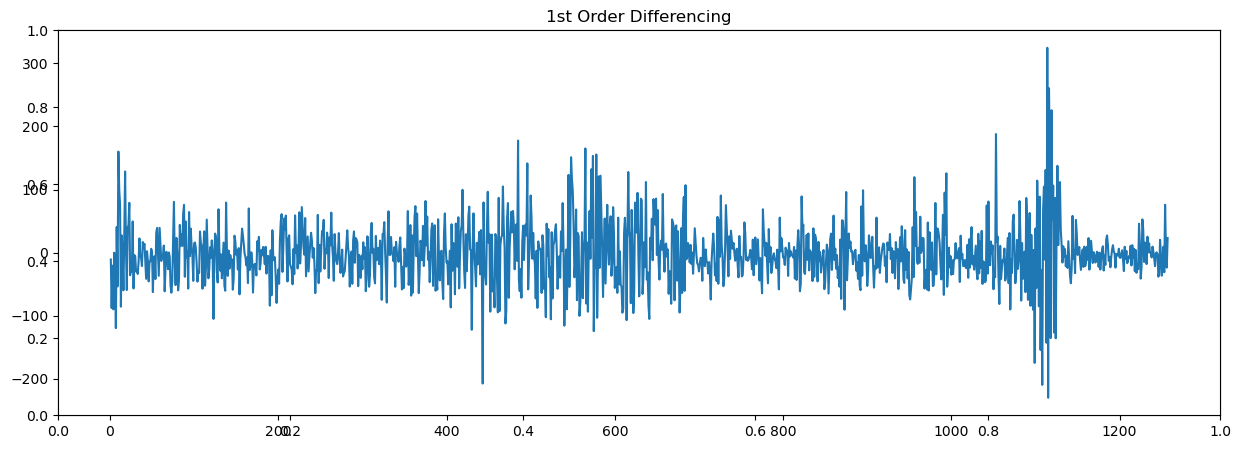

In [62]:
# Plot the result after first-order differencing
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st Order Differencing')
ax1.plot(diff1)

In [73]:
# Check stationarity after performing first-order differencing
print("1st Order Differencing: ")
check_stationarity(diff1.dropna())

1st Order Differencing: 
ADF Statistic: -11.127948
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


Through the first differencing, we got the series to be stationary as we wanted.

## SARIMA

The first model that we are going to check is using the SARIMA model.

In [74]:
# Train with SARIMAX
sar = SARIMAX(train['Close/Last'], order=(2, 1, 2,), seasonal_order=(2, 1, 2, 12)).fit()
sar.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28521D+00    |proj g|=  3.22309D-02

At iterate    5    f=  5.26948D+00    |proj g|=  9.80314D-03

At iterate   10    f=  5.21468D+00    |proj g|=  1.62706D-01

At iterate   15    f=  5.17632D+00    |proj g|=  1.25776D-03

At iterate   20    f=  5.17623D+00    |proj g|=  1.43585D-02

At iterate   25    f=  5.17590D+00    |proj g|=  3.31463D-04

At iterate   30    f=  5.17584D+00    |proj g|=  5.29099D-03

At iterate   35    f=  5.17565D+00    |proj g|=  1.23371D-02

At iterate   40    f=  5.17559D+00    |proj g|=  2.16571D-03

At iterate   45    f=  5.17559D+00    |proj g|=  5.51095D-04

At iterate   50    f=  5.17558D+00    |proj g|=  1.67183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Close/Last   No. Observations:                 1000
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -5175.584
Date:                            Mon, 19 Aug 2024   AIC                          10369.168
Time:                                    20:25:12   BIC                          10413.220
Sample:                                         0   HQIC                         10385.921
                                           - 1000                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0937      0.069     -1.356      0.175      -0.229       0.042
ar.L2         -0.9366      0.069    -13.650      0.000      -1.071      -0.802
ma.L1          0.1077      0.075      1.445      0.149      -0.038       0.254
ma.L2          0.9231      0.077     12.007      0.000       0.772       1.074
ar.S.L12      -1.0497      0.333     -3.151      0.002      -1.703      -0.397
ar.S.L24      -0.0558      0.031     -1.797      0.072      -0.117       0.005
ma.S.L12      -0.0054      0.347     -0.016      0.988      -0.686       0.675
ma.S.L24      -0.9946      0.336     -2.960      0.003      -1.653      -0.336
sigma2      1986.6213   3.66e-05   5.43e+07      0.000    1986.621    1986.621
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                75.42
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.26
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+24. Standard errors may be unstable.
"""

Using SARIMAX model can predict the future values based on historical data. We also determine the number of past values and error (order) and the pattern/intervals (seasonal order).

In [75]:
# Predict Train-Test Set
sar_pred_test = sar.predict(start=test.index[0], end=test.index[-1], dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)

# Check column names
print("SAR Prediction Columns:", sar_pred_test.columns)

# Rename column if necessary
sar_pred_test.columns = ['Close/Last_predict']

# Concatenate with actual test-set
act_vs_pred_sar = pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar


SAR Prediction Columns: Index(['predicted_mean'], dtype='object')


,Date,Close/Last,Close/Last_predict
1000,2020-08-25,3443.62,3475.066492
1001,2020-08-24,3431.28,3474.244096
1002,2020-08-21,3397.16,3474.642251
1003,2020-08-20,3385.51,3468.690857
1004,2020-08-19,3374.85,3461.974642
...,...,...,...
1253,2019-08-23,2847.11,2945.027796
1254,2019-08-22,2922.95,2946.942235
1255,2019-08-21,2924.43,2940.296669
1256,2019-08-20,2900.51,2940.737717


- Through this, we could see the comparison of both real value and predicted values.
- Also remember the importance of setting the dynamic to true which allows the model to update its predictions as new data becomes available.
- Initially the prediction column was named as 'predicted_mean', therefore we changed the name into 'Close/Last_predict' for a more simplified call.

In [77]:
# Ensure that test contains only numeric values
test_numeric = test.select_dtypes(include=[np.number])
print("Test Data Types:\n", test_numeric.dtypes)

# Check if alignment is correct
if test_numeric.shape[0] != sar_pred_test.shape[0]:
    raise ValueError("Mismatch in the number of rows between test and predictions.")

# Concatenate with actual test-set
act_vs_pred_sar = pd.concat([test_numeric.reset_index(drop=True), sar_pred_test.reset_index(drop=True)], axis=1)
print(act_vs_pred_sar.head())

# Ensure that values are numeric
test_values = test_numeric.values.flatten()  # Flatten to make sure it is a 1D array
sar_pred_test_values = sar_pred_test['Close/Last_predict'].values.flatten()

# Calculate MAE and RMSE
mae_test = mean_absolute_error(test_values, sar_pred_test_values)
rmse_test = np.sqrt(mean_squared_error(test_values, sar_pred_test_values))

print('MAE Test : ', mae_test)
print('RMSE Test : ', rmse_test)

Test Data Types:
 Close/Last    float64
dtype: object
   Close/Last  Close/Last_predict
0     3443.62         3475.066492
1     3431.28         3474.244096
2     3397.16         3474.642251
3     3385.51         3468.690857
4     3374.85         3461.974642
MAE Test :  206.98447373850485
RMSE Test :  294.95110867790635


The average value of error is about 207 (in this case dollars) and the root mean squared error is about 295 (dollars). Which we can conclude that the error this model made is about 207-295 dollars. Which is quite the number if we are talking about money, but we will see how well it can predict with another type of model.

## Holt's Winters


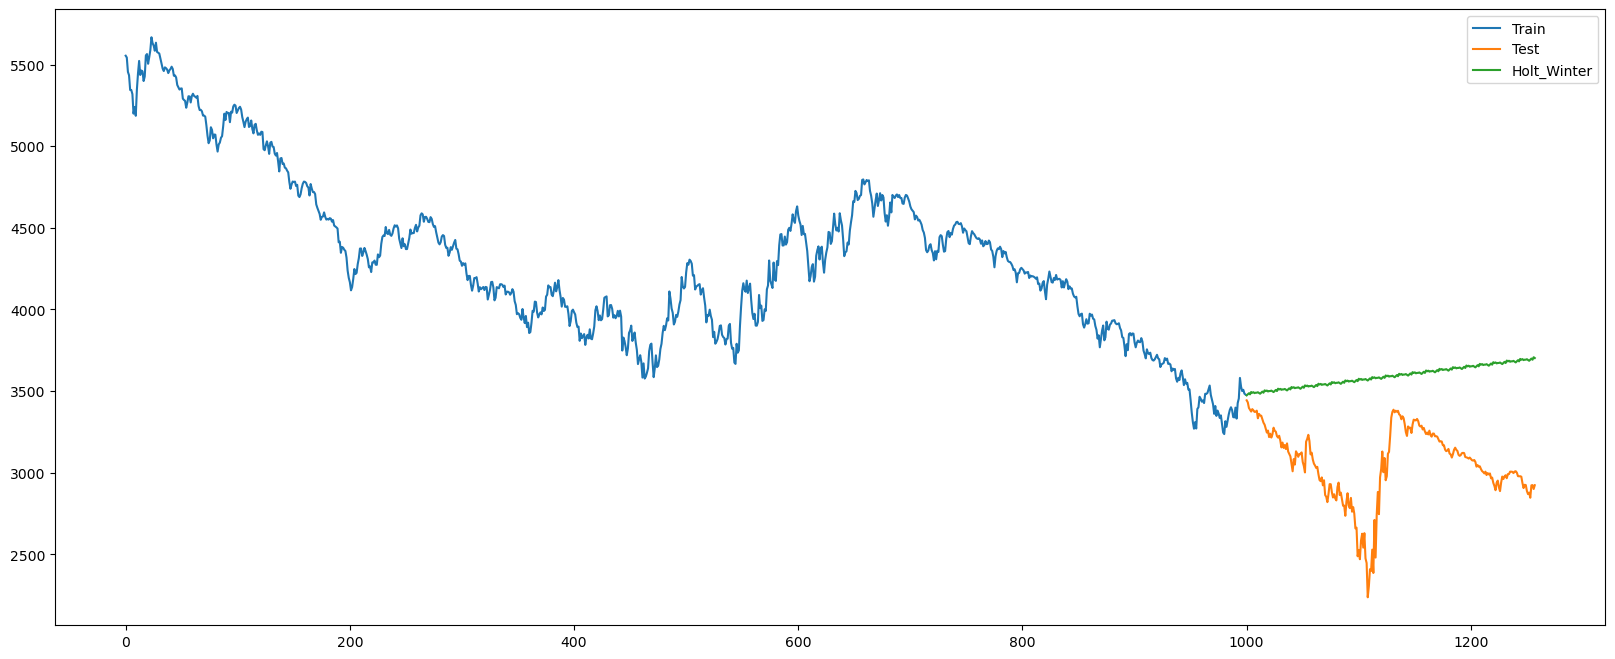

In [67]:
# Fit the model
fit1 = ExponentialSmoothing(np.asarray(train['Close/Last']),
                            seasonal_periods=12,
                            trend='additive',
                            seasonal='multiplicative').fit()

# Forecast and update the test DataFrame
y_hat_avg = test.copy()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(train['Close/Last'], label='Train')
plt.plot(test['Close/Last'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

- Holt-Winters Exponential Smoothing model can be suitable for financial forecasting, thats why we are going to test this model. 
- The additive trend assumes that any increase or decrease over time is consistent.
- Multiplicative seasonality assumes that seasonal patterns multiply the base value (grows/shrinks proportionally).
- The graph can help to visually assess the model's accuracy.

In [68]:
# Calculate and print error metrics
mae = mean_absolute_error(test['Close/Last'], y_hat_avg['Holt_Winter'])
rmse = np.sqrt(mean_squared_error(test['Close/Last'], y_hat_avg['Holt_Winter']))

print("MAE :", mae)
print("RMSE :", rmse)

mae : 537.2157101206041
rmse : 590.8929912942923


The average error of the Holt's Winter model is 537 and the root mean squared error is 591. This means that the model has a value error around 537-591 dollars. This is an even greater error than the SARIMAX model, so this model isn't very suitable for the data.

## Hyperparameter Tuning

In [69]:
# Grid Search for Exponential Smoothing
trends = ['additive', 'multiplicative']
seasonals = ['additive', 'multiplicative']
best_mae = float('inf')
best_params = None

for trend, seasonal in itertools.product(trends, seasonals):
    try:
        model = ExponentialSmoothing(train['Close/Last'], 
                                      trend=trend, 
                                      seasonal=seasonal, 
                                      seasonal_periods=12).fit()
        forecast = model.forecast(len(test))
        mae = mean_absolute_error(test['Close/Last'], forecast)
        if mae < best_mae:
            best_mae = mae
            best_params = (trend, seasonal)
    except Exception as e:
        print(f"Error with params trend={trend}, seasonal={seasonal}: {e}")

print(f"Best parameters: trend={best_params[0]}, seasonal={best_params[1]}")

# Compare with SARIMA
sarima_model = SARIMAX(train['Close/Last'], 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.forecast(len(test))
sarima_mae = mean_absolute_error(test['Close/Last'], sarima_forecast)

print(f"SARIMA MAE: {sarima_mae}")


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best parameters: trend=additive, seasonal=multiplicative
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29879D+00    |proj g|=  5.29466D-02


 This problem is unconstrained.



At iterate    5    f=  5.27023D+00    |proj g|=  7.58589D-03

At iterate   10    f=  5.17649D+00    |proj g|=  5.25972D-03

At iterate   15    f=  5.17645D+00    |proj g|=  5.33554D-04

At iterate   20    f=  5.17638D+00    |proj g|=  5.97731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   3.817D-06   5.176D+00
  F =   5.1763736144510641     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
SARIMA MAE: 203.976209233925


The main objective of hyperparameter tuning is to find the best model along with the hyperparameter (setting) for the most accurate predictions. Through looking at the average error, we get the best model and its settings. We found SARIMAX model with additive trend, multiplicative seasonality, 1 lag observations, 1 number differences, and 1 lagged forecast is the most accurate.

## Model Saving

In [70]:
# Save the SARIMA model
joblib.dump(sarima_model, 'best_sarima_model.pkl')
print("Saved the best SARIMA model.")

Saved the best SARIMA model.


The model is then saved, so we can use it on another time.

## Model Inference

In [71]:
# Load the SARIMA model
sarima_model = joblib.load('best_sarima_model.pkl')

# Read the new data from CSV
new_data = pd.read_csv('HistoricalData_1724051183988.csv')

# Convert the "Date" column to datetime format
new_data["Date"] = pd.to_datetime(new_data["Date"])

# Set the "Date" column as the index if needed
new_data.set_index("Date", inplace=True)

# Drop unnecessary columns
new_data = new_data.drop(labels=['Open', 'High', 'Low'], axis=1, errors='ignore')

# Forecast using the SARIMA model
# Use the same number of periods as you want to forecast ahead
forecast_periods = len(new_data)
sarima_forecast = sarima_model.get_forecast(steps=forecast_periods)
forecast = sarima_forecast.predicted_mean

# Optionally, you can also get the confidence intervals
confidence_intervals = sarima_forecast.conf_int()

# Print or process the forecast results
print("Forecasted Values:")
print(forecast)

print("\nConfidence Intervals:")
print(confidence_intervals)

# If you want to include the forecast in your new_data DataFrame
new_data['Forecast'] = forecast.values
print("\nNew Data with Forecast:")
print(new_data)


Forecasted Values:
1000    3475.048430
1001    3470.385080
1002    3469.269251
1003    3463.579702
1004    3459.659307
           ...     
1245    2951.527426
1246    2951.572006
1247    2953.359550
1248    2955.197191
1249    2952.517052
Name: predicted_mean, Length: 250, dtype: float64

Confidence Intervals:
      lower Close/Last  upper Close/Last
1000       3387.105078       3562.991782
1001       3346.920822       3593.849339
1002       3319.105705       3619.432797
1003       3291.330374       3635.829030
1004       3268.289103       3651.029511
...                ...               ...
1245       1723.893669       4179.161184
1246       1721.016050       4182.127962
1247       1719.888996       4186.830105
1248       1718.819502       4191.574880
1249       1713.253840       4191.780264

[250 rows x 2 columns]

New Data with Forecast:
            Close/Last     Forecast
Date                               
2024-08-16     5554.25  3475.048430
2024-08-15     5543.22  3470.385080
202

To make sure it works with unknown data, we made a data dummy with 1 year of the most recent data and tested it using the model that we have saved before. Here you can see the forecasted values along with the confidence interval (upper and lower value).

## Conclusion

Analyzing S&P 500 stock data reveals that the SARIMAX model is particularly effective for forecasting this index. By setting the order and seasonal order to (1, 1) with a seasonality of 12, the model achieves an average prediction error of $204-$295. This model captures the S&P 500's consistent growth and proportional value changes, making it suitable for market trend prediction.

However, the model has limitations. Future improvements could include incorporating additional features and macroeconomic indicators, employing hybrid or ensemble methods, and regularly updating and backtesting the model with historical data. These enhancements will help address the model's reliance on past patterns and mitigate the risk of overfitting.

Incorporating a time series model into your analysis can significantly enhance investment strategies, improve risk management, and guide strategic decision-making. It offers valuable insights into market trends, economic health, and investor sentiment, enabling better portfolio optimization, market shift anticipation, and personalized client advice, thereby increasing profitability and competitive advantage.